# Simple D→R→I→O Kinetics Test

**Purpose**: Test kinetic behavior of simple drug-response cascade without S3/config complexity

**System**: D → R1 → I1_1 → O cascade with drug D down-regulating R1

**Focus**: Pure kinetic testing of Oa response to drug treatment

## Initial Setup

Simple path configuration for proper module imports

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")



Project path set to: c:\Github\new-peak-project\src


## Imports

Minimal imports focusing only on model creation and simulation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from models.Specs.ModelSpec4 import ModelSpec4
from models.Specs.Drug import Drug
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

print("Imports complete")

Imports complete


## 1. Create Simple D→R→I→O Model

Create the basic cascade with 1 drug, 1 receptor, 1 intermediate layer

In [3]:
# Initialize model specification with 1 intermediate layer
model_spec = ModelSpec4(num_intermediate_layers=1)

# Generate network FIRST (creates R1, I1_1, O)
model_spec.generate_specifications(
    num_cascades=1,
    num_regulations=0,    # No feedback for simplicity
    random_seed=42,
    verbose=1
)

# Create drug D that down-regulates R1
drug_d = Drug(
    name="D",
    start_time=500.0,     # Drug applied at time 500 (allows system to reach steady state)
    default_value=1.0,    # Drug concentration
    regulation=["R1"],    # Regulates receptor R1
    regulation_type=["down"]  # Down-regulation decreases activation
)

# Add drug to model (now R1 exists)
model_spec.add_drug(drug_d)
print(f"Drug added: {drug_d}")

print("Network specifications:")
print(f"  Receptors: {model_spec.receptors}")
print(f"  Intermediate: {model_spec.intermediate_layers[0]}")
print(f"  Outcomes: {model_spec.outcomes}")

Drug added: Drug(D, 500.0, ['R1'], ['down'])
Network specifications:
  Receptors: ['R1']
  Intermediate: ['I1_1']
  Outcomes: ['O']


## 2. Generate Model with Controlled Parameters

Create the actual model with parameter ranges designed for signal propagation

In [4]:
# Generate the model
model = model_spec.generate_network(
    network_name="SimpleDRO_Kinetics",
    mean_range_species=(50, 150),      # Initial concentrations
    rangeScale_params=(0.8, 1.2),      # ±20% variation
    rangeMultiplier_params=(0.9, 1.1), # Small additional variation
    random_seed=42,
    receptor_basal_activation=True     # Receptors have basal activation
)

print(f"Model created: {len(model.reactions)} reactions")
print(f"States: {list(model.states.keys())[:10]}...")  # Show first 10 states

Model created: 6 reactions
States: ['R1a', 'R1', 'I1_1a', 'I1_1', 'Oa', 'O']...


In [5]:
print(model.get_antimony_model())

model SimpleDRO_Kinetics

J0: R1a -> R1; Vmax_J0*R1a/(Km_J0 + R1a)
J1: R1 -> R1a; Kc_J1*R1/(Km_J1 + R1)/(1 + D/Ki0_J1)
J2: I1_1a -> I1_1; Vmax_J2*I1_1a/(Km_J2 + I1_1a)
J3: I1_1 -> I1_1a; (Kc0_J3*R1a)*I1_1/(Km_J3 + I1_1)
J4: Oa -> O; Vmax_J4*Oa/(Km_J4 + Oa)
J5: O -> Oa; (Kc0_J5*I1_1a)*O/(Km_J5 + O)

# State variables in the system
R1a=0
R1=123
I1_1a=0
I1_1=126
Oa=0
O=94

# Parameters in the system
Km_J0=103.15377754210397
Vmax_J0=9.548267987927224
Km_J1=109.60185376826276
Kc_J1=1.1885748349506415
Ki0_J1=0.009173539435507999
Km_J2=90.06213568148742
Vmax_J2=8.796205717533443
Km_J3=120.4390747264928
Kc0_J3=0.11163263871158213
Km_J4=104.34805368495678
Vmax_J4=8.966636948705082
Km_J5=110.70017850434297
Kc0_J5=0.10304720449787655

# Other variables in the system
D := piecewise(0, time < 500.0, 1.0)


end


In [305]:
# Parameters for linear signal propagation: R -> I -> O cascade
# All Michaelis constants set high to operate in linear regime (Km >> substrate concentrations)
# Total pools: R_total ≈ 123, I_total ≈ 126, O_total ≈ 94

# 1. R module: Basal activation without drug
# Target: R1a ≈ 0.5 × R_total when D=0 (to see clear signal)
# k0 = Vmax_J0/Km_J0, k1 = Kc_J1/Km_J1
model.set_parameter("Km_J0", 500)  # High Km for linear kinetics
model.set_parameter("Vmax_J0", 50.0)  # Sets k0 = 0.1
model.set_parameter("Km_J1", 500)  # High Km for linear kinetics
model.set_parameter("Kc_J1", 50.0)  # Sets k1 = 0.1 → α_R = k1/(k0+k1) = 0.5
model.set_parameter("Ki0_J1", 0.01)  # Strong inhibition by D: when D=1, k1 becomes k1/101

# 2. I module: Activation by R1a, linear propagation
# Target: I1_1a ≈ (k3/k2) × R1a × I_total, with (k3/k2) chosen for proper scaling
# Ensure k3 × [R1a] ≪ k2 for linearity (use R1a_max ≈ 61.5)
model.set_parameter("Km_J2", 500)  # High Km for linear kinetics
model.set_parameter("Vmax_J2", 307.5)  # Sets k2 = 0.615 (Vmax_J2 = k2 × Km_J2)
model.set_parameter("Km_J3", 500)  # High Km for linear kinetics
model.set_parameter("Kc0_J3", 0.5)  # Sets k3 = 0.001 (Kc0_J3 = k3 × Km_J3)

# 3. O module: Activation by I1_1a, linear propagation
# Target: Oa ≈ (k5/k4) × I1_1a × O_total
# Ensure k5 × [I1_1a] ≪ k4 for linearity (use I1_1a_max ≈ 12.6)
model.set_parameter("Km_J4", 500)  # High Km for linear kinetics
model.set_parameter("Vmax_J4", 63.0)  # Sets k4 = 0.126 (Vmax_J4 = k4 × Km_J4)
model.set_parameter("Km_J5", 500)  # High Km for linear kinetics
model.set_parameter("Kc0_J5", 0.5)  # Sets k5 = 0.001 (Kc0_J5 = k5 × Km_J5)

# Initial conditions (using the default values from your model)
# To test proportionality, you can vary R1 while keeping R_total constant
# or vary both R1 and R1a to test different R_total
model.set_state("R1", 123)  # R_total = R1 + R1a = 123
model.set_state("R1a", 0)
model.set_state("I1_1", 126)
model.set_state("I1_1a", 0)
model.set_state("O", 94)
model.set_state("Oa", 0)

In [330]:
# Parameters for stronger signal propagation with minimal attenuation
# Strategy: Reduce downstream deactivation rates and increase activation strengths
# Target: R_active ~80, I_active ~80, O_active ~60-70 (O_total=94 limits max)

# 1. R module: Maintain ~65% activation (R1a ≈ 80)
### --- Deactivation
model.set_parameter("Km_J0", 500)  # Linear regime
model.set_parameter("Vmax_J0", 27)  # k0 = 0.08
### --- Activation 
model.set_parameter("Km_J1", 500)  # Linear regime
model.set_parameter("Kc_J1", 50)  # k1 = 0.148 → α_R = 0.649
model.set_parameter("Ki0_J1", 0.01)  # Strong drug inhibition

# 2. I module: Reduce attenuation by decreasing deactivation and increasing activation
### --- Deactivation
model.set_parameter("Km_J2", 500)  # Linear regime
model.set_parameter("Vmax_J2", 21.5)  # Reduced from 100: k2 = 0.1 (slower I deactivation)
### --- Activation
model.set_parameter("Km_J3", 500)  # Linear regime
model.set_parameter("Kc0_J3", 0.5)  # Increased from 0.794: k3 = 0.004 (stronger R→I activation)

# 3. O module: Reduce attenuation similarly
### --- Deactivation
model.set_parameter("Km_J4", 500)  # Linear regime
model.set_parameter("Vmax_J4", 22)  # Reduced from 50: k4 = 0.05 (slower O deactivation)
### --- Activation
model.set_parameter("Km_J5", 500)  # Linear regime
model.set_parameter("Kc0_J5", 0.5)  # Increased from 0.53: k5 = 0.002 (stronger I→O activation)

# Initial conditions (using your original totals)
model.set_state("R1", 123)
model.set_state("R1a", 0)
model.set_state("I1_1", 126)
model.set_state("I1_1a", 0)
model.set_state("O", 94)
model.set_state("Oa", 0)

## 3. Test Basic Kinetics (Extended Timeframe)

Simulate single model with drug starting at t=500, simulation to t=1000

In [331]:
# Create solver
solver = RoadrunnerSolver()

# Compile model and simulate with extended timeframe
solver.compile(model.get_sbml_model())
result = solver.simulate(start=0, stop=1000, step=101)  # 0-1000 with 101 points

print("Simulation complete (0-1000 timeframe)")
print(f"Oa at t=0: {result['Oa'].values[0]:.2f}")
print(f"Oa at t=500 (drug start): {result['Oa'].values[50]:.2f}")
print(f"Oa at t=1000: {result['Oa'].values[-1]:.2f}")

Simulation complete (0-1000 timeframe)
Oa at t=0: 0.00
Oa at t=500 (drug start): 63.12
Oa at t=1000: 7.04


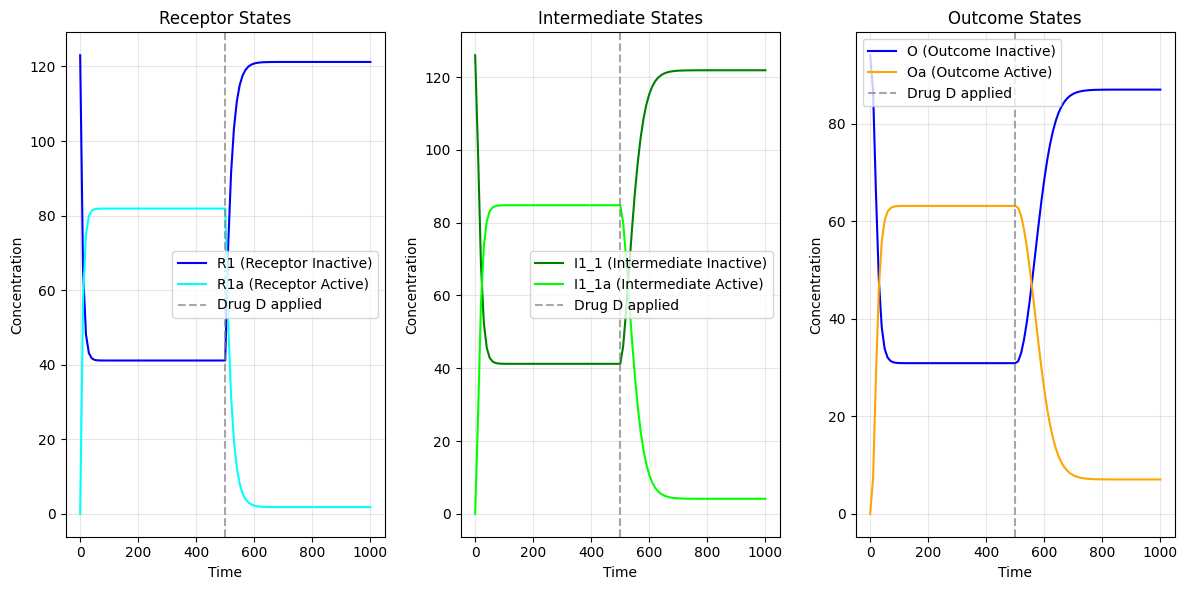

Pre-drug peaks (t < 500):
R1a: peak = 81.881 at t = 340.0
I1_1a: peak = 84.791 at t = 340.0
Oa: peak = 63.121 at t = 340.0


In [332]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Subplot 1: R1 and R1a
plt.subplot(1, 3, 1)
plt.plot(result['time'], result['R1'], label='R1 (Receptor Inactive)', color='blue')
plt.plot(result['time'], result['R1a'], label='R1a (Receptor Active)', color='cyan')
plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Receptor States')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: I1_1 and I1_1a
plt.subplot(1, 3, 2)
plt.plot(result['time'], result['I1_1'], label='I1_1 (Intermediate Inactive)', color='green')
plt.plot(result['time'], result['I1_1a'], label='I1_1a (Intermediate Active)', color='lime')
plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Intermediate States')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: O and Oa
plt.subplot(1, 3, 3)
plt.plot(result['time'], result['O'], label='O (Outcome Inactive)', color='blue')
plt.plot(result['time'], result['Oa'], label='Oa (Outcome Active)', color='orange')
plt.axvline(x=500, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Outcome States')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
# Quantitatively report peak values of activated species before treatment (t < drug_start_time)
pre_drug = result[result['time'] < 500]

peaks = {}
for species in ['R1a', 'I1_1a', 'Oa']:
    idx = pre_drug[species].idxmax()
    peak_value = float(pre_drug.loc[idx, species])
    peak_time = float(pre_drug.loc[idx, 'time'])
    peaks[species] = (peak_value, peak_time)

print(f"Pre-drug peaks (t < {500}):")
for species, (value, t_peak) in peaks.items():
    print(f"{species}: peak = {value:.3f} at t = {t_peak:.1f}")